# Loading Packages

In [1]:
import os
import torch
from utils.visualize       import visualize_images_from_classes
from utils.datasets        import returnDataLoader
from utils.model_execution import runFMA, runDLA
from utils.analysis        import print_analysis

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: xpu


# Load Patches

In [4]:
while True:
    data_dir = input("Please enter the dataset directory, for example: ./data/: ") or "./data/"

    if not os.path.isdir(data_dir):
        print(f"Directory '{data_dir}' does not exist. Please try again.\n")
        continue
    print("\nDataset directory confirmed.\n")

    break

classes            = []
artifact_free      = input("Please enter the name of the artifact free folder (e.g., artifact_free): ").strip()
artifact_free_path = os.path.join(data_dir, artifact_free)

if artifact_free and os.path.isdir(artifact_free_path):
    classes.append(artifact_free)
    print(f"Folder '{artifact_free_path}' exists and was added as artifact free.")
else:
    if artifact_free:
        print(f"Folder '{artifact_free_path}' does not exist. Please check the name.")

artifact      = input("Please enter the name of the artifact folder (e.g., artifact): ").strip()
artifact_path = os.path.join(data_dir, artifact)

if artifact and os.path.isdir(artifact_path):
    classes.append(artifact)
    print(f"Folder '{artifact_path}' exists and was added as artifact.")
else:
    if artifact:
        print(f"Folder '{artifact_path}' does not exist. Please check the name.")

if classes:
    print("\nDataset loaded successfully.")
else:
    print("\nNo valid class folders were provided. Defaulting to sample classes.")
    classes = ['artifact_free', 'blur']



Dataset directory confirmed.


No valid class folders were provided. Defaulting to sample classes.


# Random visualization of different classes

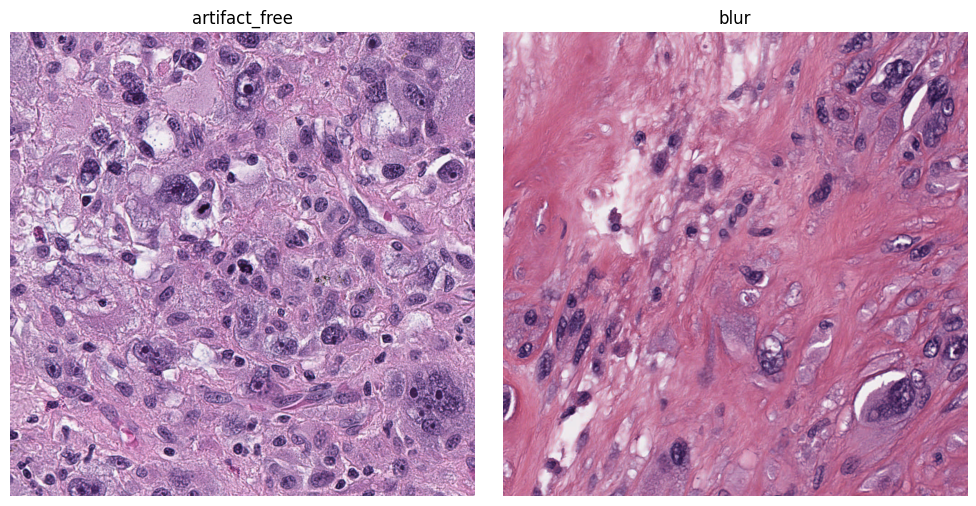

In [5]:
visualize_images_from_classes(data_dir, classes)

# Prepare data for classification

In [6]:
dataloader = returnDataLoader(data_dir, classes)
print("Total dataset size (samples): ", len(dataloader.dataset))


Total dataset size (samples):  18495


# Classify images with different models

### FMA

In [8]:
runFMA(dataloader, device, './models/fma_binary.pth')

Epoch 1 [test]: 100%|██████████| 1156/1156 [09:52<00:00,  1.95it/s]


### DLA

In [7]:
runDLA(dataloader, device, './models/dla_binary.pth')

/home/sysop/programming/python/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sysop/programming/python/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 [test]: 100%|██████████| 1156/1156 [06:44<00:00,  2.86it/s]


### KBA

# Analysis

In [4]:
print_analysis('./results/fma_results.csv')


Percentage of predicted Artifact: 99.16%
Percentage of predicted Artifact Free: 0.84%


In [5]:
print_analysis('./results/dla_results.csv')

Percentage of predicted Artifact: 99.39%
Percentage of predicted Artifact Free: 0.61%
